In [64]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [67]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [68]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")
#print(X.groupby(['Target']).count())
X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0.0).sum())
print("Positive Examples : ",(X['Target']==1.0).sum())
print("Neutral Examples : ",(X['Target']==2.0).sum())


Number of Examples :  18187 

Number of Examples after removing duplicates:  17852 

Number of words before cleaning :  672140
Number of words after cleaning :  452084

******************

Negative Examples :  2193
Positive Examples :  6672
Neutral Examples :  8987


In [69]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

0        mercuri system receiv contract award base new ...
1        progress second quarter revenu exce guidanc in...
2        acuiti brand declar quarterli dividend atlanta...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
17847    appl app store polici updat affect microsoft g...
17848    investor action remind schall law firm announc...
17849    amwel propos term million ipo amwel seek rais ...
17850    jim cramer preview lennar fedex adob earn repo...
17851    rosen respect lead law firm remind alteryx inc...
Name: Article, Length: 17852, dtype: object


In [70]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']


print("Neutral Examples in Training after OverSampling: ",(train['Target']==2).sum())
print("Negative Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train['Target']==1).sum())

train.to_csv (r'General1.csv', index = False, header=True)
test.to_csv (r'General2.csv', index = False, header=True)
val.to_csv (r'General3.csv', index = False, header=True)

Neutral Examples in Training after OverSampling:  5032
Negative Examples in Training after OverSampling:  5032
Positive Examples in Training after OverSampling:  5032


In [71]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General1.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'General2.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'General3.csv',format = 'csv',fields = fields,skip_header = True)


TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))   



Size of TEXT vocabulary: 11080
Size of LABEL vocabulary: 3
[('stock', 7261), ('earn', 5866), ('compani', 3755), ('report', 3490), ('inc', 3338), ('result', 2778), ('quarter', 2588), ('announc', 2502), ('busi', 2378), ('market', 2113)]


In [72]:
def find_accuracy(preds, y):
   
    temp = torch.log_softmax(preds, dim = 1)
    _, y_pred = torch.max(temp, dim = 1) 
    valid = (y_pred == y).float() 
    accur = valid.sum() / len(valid)
    return accur,y_pred,y

def Loss_Optimizer (model,valueLR):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [73]:
def train(model,data,lr,optimizer,criterion):
        
    #optimizer,criterion=Loss_Optimizer (model,lr)
    #criterion = criterion.to(device)
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(0)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [74]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(0)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [75]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1, 2])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix, with normalization')
    

In [76]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

In [77]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [78]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        return self.fc(hidden)

In [79]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [83]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 3
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(11080, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(11080, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch :  5  Train Loss :  0.4384704321622849   Train Acc :  0.8259889006614685   Valid Loss :  0.4919206847747167  Val Acc :  0.8066780765851339
Epoch :  10  Train Loss :  0.21614575137694678   Train Acc :  0.9179379145304362   Valid Loss :  0.5493046840031942  Val Acc :  0.8335637847582499
Epoch :  15  Train Loss :  0.12319739013910294   Train Acc :  0.9535752495129903   Valid Loss :  0.7463026344776154  Val Acc :  0.8416816393534342
Epoch :  20  Train Loss :  0.08912314406285683   Train Acc :  0.9671621481577556   Valid Loss :  0.8309407830238342  Val Acc :  0.8401404619216919
Epoch :  25  Train Loss :  0.05408142258723577   Train Acc :  0.9801206151644389   Valid Loss :  0.9680297176043192  Val Acc :  0.8415289719899496
Epoch :  30  Train Loss :  0.04800349287688732   Train Acc :  0.9830475648244222   Valid Loss :  0.9924948811531067  Val Acc :  0.841356118520101

Time needed for Training :  1.3264996647834777

Loss in Testset :  0.9018435440957546   Accuracy in Testset :  0.8497693

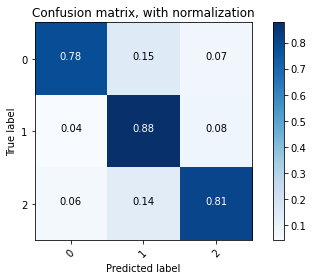

In [84]:
process_test(new_model2,30,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","best_LSTM_1_model.pt")

Epoch :  5  Train Loss :  0.48294443090756733   Train Acc :  0.8106763998667399   Valid Loss :  0.5384179949760437  Val Acc :  0.8110423485438029
Epoch :  10  Train Loss :  0.25854914511243504   Train Acc :  0.9005270044008891   Valid Loss :  0.630970964829127  Val Acc :  0.8269266287485758
Epoch :  15  Train Loss :  0.16480885247389476   Train Acc :  0.935629113515218   Valid Loss :  0.673453559478124  Val Acc :  0.8402931491533915
Epoch :  20  Train Loss :  0.1004786147425572   Train Acc :  0.9620614051818848   Valid Loss :  0.7568239669005076  Val Acc :  0.8428973158200582
Epoch :  25  Train Loss :  0.07681538710991541   Train Acc :  0.9722601453463237   Valid Loss :  0.7817508578300476  Val Acc :  0.8455216487248739
Epoch :  30  Train Loss :  0.061369818697373076   Train Acc :  0.9774712204933167   Valid Loss :  0.906541665395101  Val Acc :  0.8424853682518005

Time needed for Training :  1.0849196076393128

Loss in Testset :  0.9018191968401273   Accuracy in Testset :  0.844508628

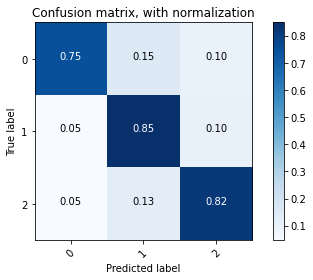

In [85]:
process_test(new_model3,30,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","best_gru_1_model.pt")